## 1. Import Libraries
---

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras import models, layers

## 2. Load Dataset
---
### Using Bitcoin-historical datasets.
---
### Features
* Timestamp - Start time of time window (60s window), in Unix time
* High - High price within time window
* Low - Low price within time window
---
I only use Timestamp, High price and Low price.

In [ ]:
df = pd.read_csv("/content/bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv")
df['price'] = (df['High']+ df['Low'])/2
df.drop(['Open','Close','Volume_(BTC)','Volume_(Currency)', 'Weighted_Price','High','Low'],axis=1, inplace=True)

df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
df = df.set_index('Timestamp')
df = df.resample('6H').mean()
df = df.dropna()

df.head()

,price
Timestamp,
2011-12-31 06:00:00,4.390000
2011-12-31 12:00:00,4.501667
2012-01-01 00:00:00,4.580000
2012-01-01 12:00:00,4.840000
2012-01-01 18:00:00,5.000000


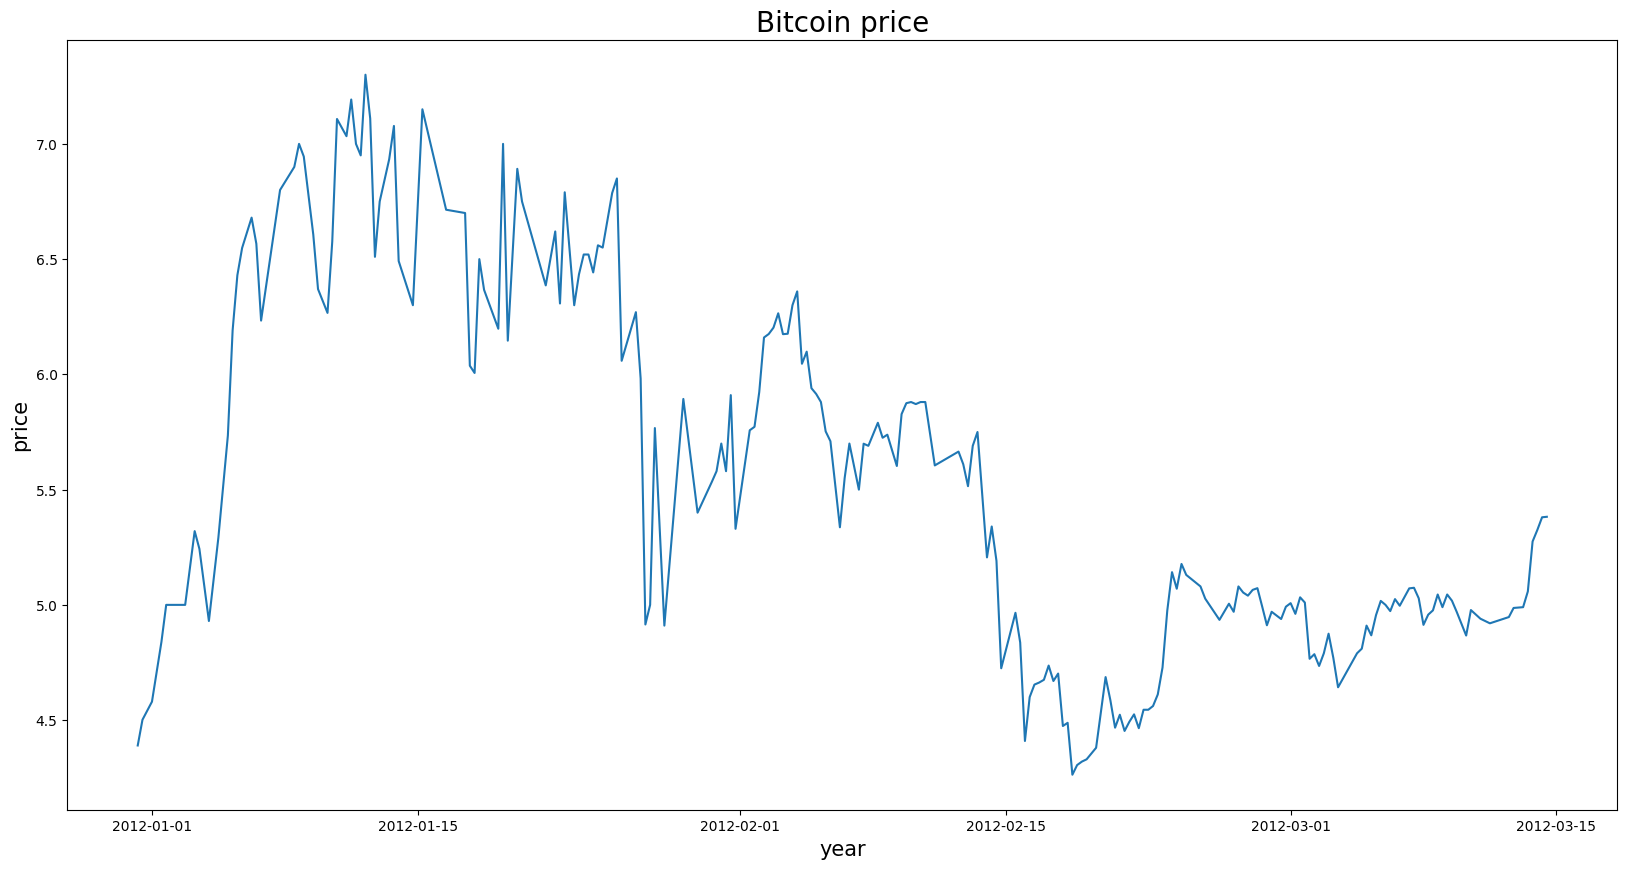

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df)
plt.title('Bitcoin price',fontsize=20)
plt.xlabel('year',fontsize=15)
plt.ylabel('price',fontsize=15)
plt.show()

## 3. Using Scaler ( MinMaxScaler )
---
### By using MinMaxScaler, The price range is (0 ~ 1) now.

In [ ]:
scaler = MinMaxScaler()
price = scaler.fit_transform(np.array(df['price']).reshape(-1,1))
df['price'] = price

## 4. Sliding window and Split Train, Test data
---
### We predict 1 data by using 50 datas.
---

### After Sliding window
* X.shape : (12965, 50, 1)
* y.shape : (12965, 1)

In [ ]:
X_l = []
y_l = []
N = len(df)
D = 50
for i in range(N-D-1):
    X_l.append(df.iloc[i:i+D])
    y_l.append(df.iloc[i+D])

X = np.array(X_l)
y = np.array(y_l)

print(X.shape, y.shape)

(166, 50, 1) (166, 1)


### After Sliding window, We split data to X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state= 100)

## 5. Make LSTM model
---

In [ ]:
m_x = layers.Input(shape = X_train.shape[1:])
m_h = layers.LSTM(10)(m_x)
m_y = layers.Dense(1)(m_h)
m = models.Model(m_x,m_y)
m.compile('adam','mse')
m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 6. Fit and Evaluate the model
---

In [ ]:
history = m.fit(X_train, y_train, epochs=500, validation_data=(X_test, y_test),verbose=0)

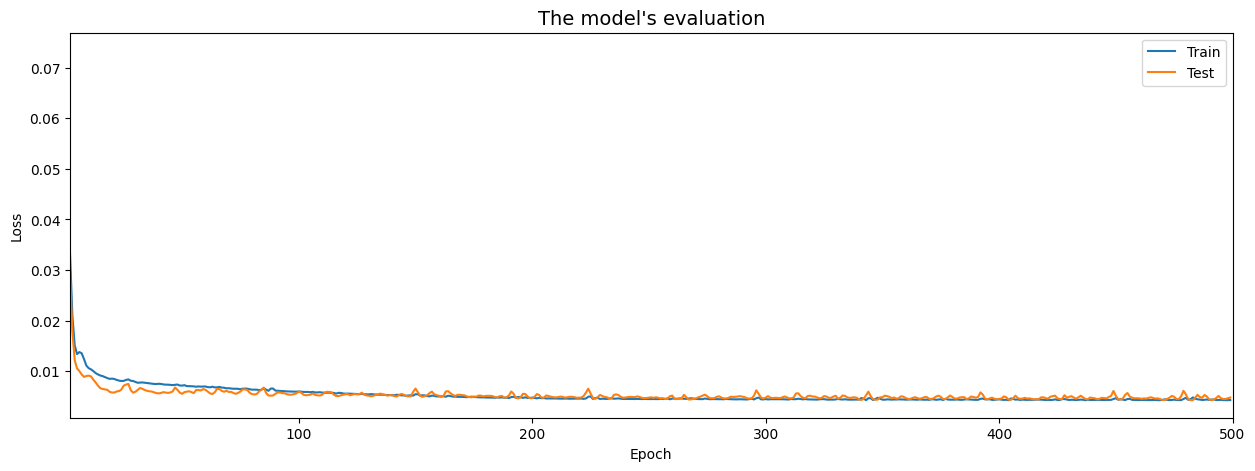

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train','Test'])
plt.title("The model's evaluation", fontsize=14)
plt.xlabel('Epoch')
plt.xlim(2,500)
plt.ylabel('Loss')
plt.show()

## 7. Predict the price!
---
### We will predict 300 datas

In [ ]:
pred = []

pr = m.predict(np.array(df[-50:]))

pred.append(pr[0])

for i in range(1,50):
    pr = m.predict(np.concatenate((np.array(df[-50+i:]), pred[:]), axis=0))
    pred.append(pr[0])

for i in range(0,250):
    pr = m.predict(np.concatenate(pred[i:],axis=0).reshape(-1,1))
    pred.append(pr[0])

2/2 [==============================] - 0s 9ms/step


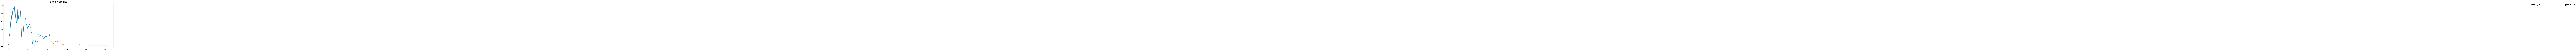

In [ ]:
pred = pd.DataFrame(pred)

pred = pred.reset_index()

pred.columns = ['z','price']

pred.drop(['z'],axis=1,inplace=True)

data = pd.concat([df.reset_index().drop('Timestamp',axis=1),pred],ignore_index=True)

plt.figure(figsize=(17,7))
plt.plot(data[-1300:-300])
plt.title("Bitcoin predict",fontsize=20)
plt.text(13200,1,"predict data",fontsize=14)
plt.text(13015,1,"- 2020/12/31",fontsize=14)
plt.plot(data[-300:])
plt.show()

![](https://www.tradingview.com/x/soDyDqe1)

### LSTM is the one of the powerful DeepLearning Algorithm. But, It can't predict the Bitcoin Price that have enormous increase never before